# Dependencies

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm, SymLogNorm, PowerNorm
from pylab import *
from math import sin, cos
from collections import OrderedDict as odict
from numpy.linalg import norm
from functools import partial

In [8]:
# Path to a data sample
data_path = '/Users/GuoZhiqi/Downloads/sub1_s99_sg.hdf5'

In [9]:
data_hdf5_file = h5py.File(data_path, 'r')

In [10]:
PartType0 = data_hdf5_file['PartType0'] # Gas particles
PartType4 = data_hdf5_file['PartType4'] # Star particles

In [11]:
# Fields
print(list(PartType0.keys()))
print(list(PartType4.keys()))

['Coordinates', 'FOFID', 'GalID', 'Masses', 'ParticleIDs', 'StarFormationRate', 'Velocities']
['Coordinates', 'FOFID', 'GFM_StellarFormationTime', 'GFM_StellarPhotometrics', 'GalID', 'Masses', 'ParticleIDs', 'Velocities']


# Projection

- Gas: weighted by StarFormation Rate 
- Star: cut of negative stellar formation time

Define $w_i$ as the weight of $i^{th}$ point. For stars, $w_i=m_i$, where $m_i$ is the mass of the particle $i$. For gases, $w_i=SFR_i$, where $SFR_i$ is the star formation rate of particle $i$. $v_i^z$ is the velocity of $i^{th}$ particle in $z$-direction.

For each bin, calculate the followings:
- mass density: $\frac{1}{N}\sum_{i=0}^{N} w_i$
- Velocity: $\frac{\sum_{i=0}^{N} w_i v_i^z}{\sum_{i=0}^{N} w_i}$ (Weighted sum of velocities)
- Velocity dispersion: $\frac{\sum_{i=0}^{N}w_i (v_i^z-\bar{v^z})^2}{\sum_{i=0}^{N}w_i}$

### Rotation function

In [12]:
def construct_rotation_matrix(rotation_angle):
    '''
    Construct rotation matrix based on Euler angles
    Reference: http://mathworld.wolfram.com/EulerAngles.html
    
    Param: rotation_angle [phi, theta, psi] in python list
    return: rotation_matrix in numpy array, shape (3,3)
    '''
    # Extract Euler angle
    phi, theta, psi = rotation_angle
    # Construct rotation matrix in numpy array
    rotation_matrix = np.array(
(
    (cos(psi)*cos(phi)-cos(theta)*sin(phi)*sin(psi) , cos(psi)*sin(phi)+cos(theta)*cos(phi)*sin(psi) , sin(psi)*sin(theta)) , 
(-sin(psi)*cos(phi)-cos(theta)*sin(phi)*cos(psi) , -sin(psi)*sin(phi)+cos(theta)*cos(phi)*cos(psi) , cos(psi)*sin(theta)) ,
(sin(theta)*sin(phi) , -sin(theta)*cos(phi) , cos(theta))
)
    )
    return rotation_matrix

def rotate_batch_coordinates(rotation_angle, coordinates):
    '''
    Rotate batch of coordinates
    param rotation_angle: [phi, theta, psi] in python list
    param coordinates: Batch coordinates in numpy array shape (N, 3)
    return: Rotated coordinates in numpy array shape (N, 3)
    '''
    rotation_matrix = construct_rotation_matrix(rotation_angle)
    return rotation_matrix.dot(coordinates.T).T 

### Extract array from hdf5

In [13]:
(norm(PartType4['Coordinates'][:], axis=1)<10).sum()

709286

In [14]:
def get_rotated_coordinates(data,  rotation_angle=[0,0,0], cutoff_radius):
    # Load hdf5 data
    PartType0 = data_hdf5_file['PartType0'] # Gas particles
    PartType4 = data_hdf5_file['PartType4'] # Star particles
    
    
    # Filter: Cut off distance
    gas_filter = np.where(norm(PartType0['Coordinates'][:], axis=1)<cutoff_radius)[0]
    # Gas, get coordinates StarFormationRate and Velocities
    gas_dict = odict([
        ('Coordinates', rotate_batch_coordinates(rotation_angle, PartType0['Coordinates'][:][gas_filter])),
        ('weights', PartType0['StarFormationRate'][:][gas_filter].reshape(-1)), 
        ('Velocities', rotate_batch_coordinates(rotation_angle, PartType0['Velocities'][:])[gas_filter])
    ])
    
    # Filter: For stars, GFM_StellarFormationTime should be greater than zero to be considered.
    star_filter = np.where(
        (PartType4['GFM_StellarFormationTime'][:].reshape(-1)>0)&
        (norm(PartType4['Coordinates'][:], axis=1)<cutoff_radius)
                          )[0]
    # Stars, get coordinates masses Velocities and GFM_StellarFormationTime
    star_dict = odict([
        ('Coordinates', rotate_batch_coordinates(rotation_angle, PartType4['Coordinates'][:][star_filter])),
        ('weights', PartType4['Masses'][:][star_filter].reshape(-1)),
        ('Velocities', rotate_batch_coordinates(rotation_angle, PartType4['Velocities'][:][star_filter]))
    ])
    
    return gas_dict, star_dict

### Intensity image visualization

In [15]:
# Generate 2D images
def get_weights_dist2D(particle_dict):
    weights_dist, xedges, yedges = np.histogram2d(x=particle_dict['Coordinates'][:, 0], 
                                                  y=particle_dict['Coordinates'][:, 1],
                                                  bins=100,
                                                  weights=particle_dict['weights']
                                                 )
    return weights_dist, xedges, yedges

def get_velocity_dist2D(particle_dict, weights_dist):
    n_bins = weights_dist.shape[0]
    velocities_dist, xedges, yedges = np.histogram2d(x=particle_dict['Coordinates'][:, 0], 
                                                     y=particle_dict['Coordinates'][:, 1],
                                                     weights=particle_dict['weights']*particle_dict['Velocities'][:, 2], 
                                                     bins=n_bins
                                                    )
    return np.nan_to_num(velocities_dist/weights_dist)
    #return velocities_dist

def get_dispersion_dist2D(particle_dict, weights_dist):
    n_bins = weights_dist.shape[0]
    x,y,z = particle_dict['Coordinates'].T
    vx, vy, vz = particle_dict['Velocities'].T
    particle_counts,xedges,yedges = np.histogram2d(x, y, bins=n_bins)
    vz_sum, _, _ = np.histogram2d(x, y, weights = vz, bins=n_bins)
    for edges in [xedges, yedges]:
        edges[0] = round(edges[0])-1
        edges[-1] = round(edges[-1])
    vz_bin_x = np.digitize(x, xedges)-1
    vz_bin_y = np.digitize(y, yedges)-1
    vz_avgs_hist = np.divide(vz_sum, particle_counts, where=particle_counts>0)
    vz_avgs_arr = vz_avgs_hist[vz_bin_x, vz_bin_y]
    diff_sq = (vz-vz_avgs_arr)**2
    dispersion_dist,_,_ = np.histogram2d(x, y,weights = particle_dict['weights'][:]*diff_sq, bins=n_bins)
    return np.nan_to_num(dispersion_dist/ weights_dist)


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide


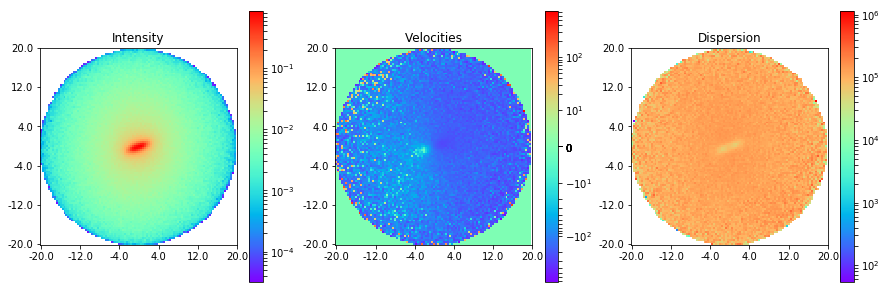

In [42]:
gas_dict, star_dict = get_rotated_coordinates(data_hdf5_file, [0,0,0], cutoff_radius=20)
star_weights_dist, xedges, yedges = get_weights_dist2D(star_dict)
star_velocity_dist = get_velocity_dist2D(star_dict,star_weights_dist)
star_dispersion_dist = get_dispersion_dist2D(star_dict, star_weights_dist)

fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k')

im0 = axs[0].imshow(star_weights_dist, 
           origin='lower', 
           cmap='rainbow',norm=LogNorm()
          )
plt.colorbar(im0, ax=axs[0])
ticks_pos = np.array([0,20,40,60,80,100])

axs[0].set_xticks(ticks_pos)
axs[0].set_xticklabels(np.round(xedges[ticks_pos]))
axs[0].set_yticks(ticks_pos)
axs[0].set_yticklabels(np.round(yedges[ticks_pos]))
axs[0].set_title('Intensity')

im1 = axs[1].imshow(star_velocity_dist, 
           origin='lower', 
           cmap='rainbow',          
           norm=SymLogNorm(linthresh=10)
          )
plt.colorbar(im1, ax=axs[1])
ticks_pos = np.array([0,20,40,60,80,100])
axs[1].set_xticks(ticks_pos)
axs[1].set_xticklabels(np.round(xedges[ticks_pos]))
axs[1].set_yticks(ticks_pos)
axs[1].set_yticklabels(np.round(yedges[ticks_pos]))
axs[1].set_title('Velocities')

im2=axs[2].imshow(star_dispersion_dist, 
                   origin='lower', 
                   cmap='rainbow',norm=LogNorm()
          )
plt.colorbar(im2, ax=axs[2])
ticks_pos = np.array([0,20,40,60,80,100])
axs[2].set_xticks(ticks_pos)
axs[2].set_xticklabels(np.round(xedges[ticks_pos]))
axs[2].set_yticks(ticks_pos)
axs[2].set_yticklabels(np.round(yedges[ticks_pos]))
axs[2].set_title('Dispersion')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide


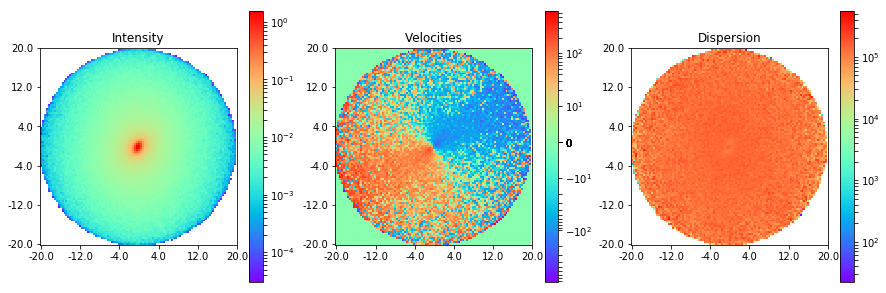

In [44]:
gas_dict, star_dict = get_rotated_coordinates(data_hdf5_file, [0,3.14/2,0], cutoff_radius=20)
star_weights_dist, xedges, yedges = get_weights_dist2D(star_dict)
star_velocity_dist = get_velocity_dist2D(star_dict,star_weights_dist)
star_dispersion_dist = get_dispersion_dist2D(star_dict, star_weights_dist)

fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k')

im0 = axs[0].imshow(star_weights_dist, 
           origin='lower', 
           cmap='rainbow',norm=LogNorm()
          )
plt.colorbar(im0, ax=axs[0])
ticks_pos = np.array([0,20,40,60,80,100])

axs[0].set_xticks(ticks_pos)
axs[0].set_xticklabels(np.round(xedges[ticks_pos]))
axs[0].set_yticks(ticks_pos)
axs[0].set_yticklabels(np.round(yedges[ticks_pos]))
axs[0].set_title('Intensity')

im1 = axs[1].imshow(star_velocity_dist, 
           origin='lower', 
           cmap='rainbow',          
           norm=SymLogNorm(linthresh=10)
          )
plt.colorbar(im1, ax=axs[1])
ticks_pos = np.array([0,20,40,60,80,100])
axs[1].set_xticks(ticks_pos)
axs[1].set_xticklabels(np.round(xedges[ticks_pos]))
axs[1].set_yticks(ticks_pos)
axs[1].set_yticklabels(np.round(yedges[ticks_pos]))
axs[1].set_title('Velocities')

im2=axs[2].imshow(star_dispersion_dist, 
                   origin='lower', 
                   cmap='rainbow',norm=LogNorm()
          )
plt.colorbar(im2, ax=axs[2])
ticks_pos = np.array([0,20,40,60,80,100])
axs[2].set_xticks(ticks_pos)
axs[2].set_xticklabels(np.round(xedges[ticks_pos]))
axs[2].set_yticks(ticks_pos)
axs[2].set_yticklabels(np.round(yedges[ticks_pos]))
axs[2].set_title('Dispersion')

In [ ]:
gas_dict, star_dict = get_rotated_coordinates(data_hdf5_file, [0,3.14/2,0], cutoff_radius=10000)

gas_weights_dist, xedges, yedges = get_weights_dist2D(gas_dict)
gas_velocity_dist = get_velocity_dist2D(gas_dict,star_weights_dist)
gas_dispersion_dist = get_dispersion_dist2D(gas_dict, star_weights_dist)

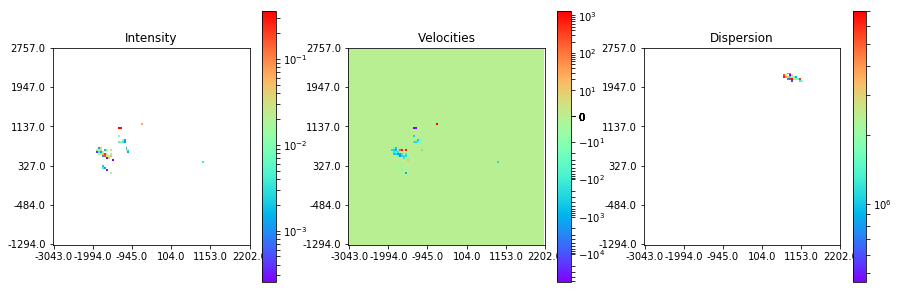

In [63]:
fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k')

im0 = axs[0].imshow(gas_weights_dist, 
           origin='lower', 
           cmap='rainbow',norm=LogNorm()
          )
plt.colorbar(im0, ax=axs[0])
ticks_pos = np.array([0,20,40,60,80,100])

axs[0].set_xticks(ticks_pos)
axs[0].set_xticklabels(np.round(xedges[ticks_pos]))
axs[0].set_yticks(ticks_pos)
axs[0].set_yticklabels(np.round(yedges[ticks_pos]))
axs[0].set_title('Intensity')

im1 = axs[1].imshow(gas_velocity_dist, 
           origin='lower', 
           cmap='rainbow',          
           norm=SymLogNorm(linthresh=10)
          )
plt.colorbar(im1, ax=axs[1])
ticks_pos = np.array([0,20,40,60,80,100])
axs[1].set_xticks(ticks_pos)
axs[1].set_xticklabels(np.round(xedges[ticks_pos]))
axs[1].set_yticks(ticks_pos)
axs[1].set_yticklabels(np.round(yedges[ticks_pos]))
axs[1].set_title('Velocities')

im2=axs[2].imshow(gas_dispersion_dist, 
                   origin='lower', 
                   cmap='rainbow',norm=LogNorm()
          )
plt.colorbar(im2, ax=axs[2])
ticks_pos = np.array([0,20,40,60,80,100])
axs[2].set_xticks(ticks_pos)
axs[2].set_xticklabels(np.round(xedges[ticks_pos]))
axs[2].set_yticks(ticks_pos)
axs[2].set_yticklabels(np.round(yedges[ticks_pos]))
axs[2].set_title('Dispersion')

In [59]:
np.where(gas_weights_dist!=0)

(array([83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85,
        86, 86, 86, 86, 87, 87]),
 array([75, 79, 80, 73, 74, 75, 76, 77, 78, 79, 71, 72, 73, 74, 75, 76, 77,
        71, 72, 74, 75, 73, 74]))

In [60]:
np.where(gas_velocity_dist!=0)

(array([83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85,
        86, 86, 86, 86, 87, 87]),
 array([75, 79, 80, 73, 74, 75, 76, 77, 78, 79, 71, 72, 73, 74, 75, 76, 77,
        71, 72, 74, 75, 73, 74]))

In [61]:
np.where(gas_dispersion_dist)

(array([83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85,
        86, 86, 86, 86, 87, 87]),
 array([75, 79, 80, 73, 74, 75, 76, 77, 78, 79, 71, 72, 73, 74, 75, 76, 77,
        71, 72, 74, 75, 73, 74]))